# Load smln and show raster

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os

from plot import set_font_size

TRIAL = 25438
SEED = 17766

class NtwkResponse(object):
    
    def __init__(self):
        pass

In [2]:
f_name_pattern = 'full_smln_rsp_trial_{}_seed_{}_{}.npy'.format(TRIAL, SEED, '{}')
path_pattern = os.path.join('lin_ridge', 'cache', f_name_pattern)

In [3]:
attrs = [
    'cell_types',
    'masks_plastic',
    'membrane',
    'p',
    'pfcs',
    'replay',
    'spks',
    'ts',
    'vs',
    'ws_plastic',
    'ws_rcr',
    'ws_up',
]

rsp = NtwkResponse()

for attr in attrs:
    path = path_pattern.format(attr)
    data = np.load(path)[0]
    for k, v in data.items():
        setattr(rsp, k, v)
        
cts = np.repeat('   ', len(rsp.cell_types))
cts[rsp.cell_types == 'P'] = 'PC'
cts[rsp.cell_types == 'I'] = 'INH'
rsp.cell_types = cts

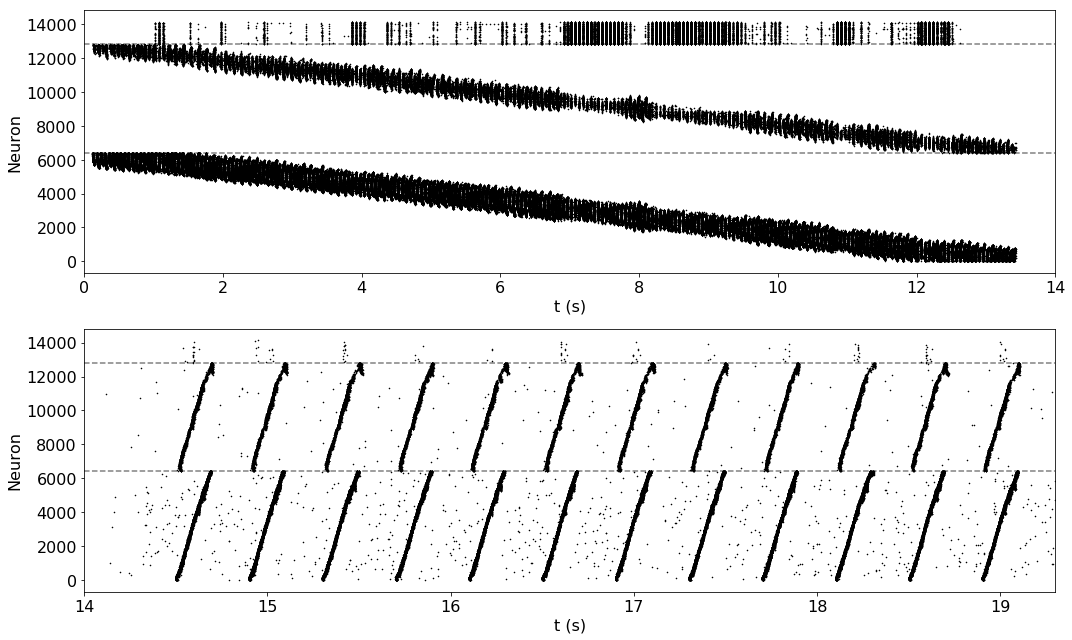

In [4]:
from lin_ridge.full_viz import raster
from lin_ridge import full_global as C
from lin_ridge import search_global as C_

fig, axs = raster(rsp.ts, rsp.spks, rsp.pfcs, rsp.cell_types, rsp.p, C, C_, fig_size=(15, 9), s=10)

In [5]:
# build true trajectory
t_mask_traj = (C.TRAJ_START_T <= rsp.ts) & (rsp.ts < C.TRAJ_END_T)
ts_traj = rsp.ts[t_mask_traj]

traj_start_x = rsp.p['AREA_W'] / 2
traj_end_x = -rsp.p['AREA_W'] / 2

traj_start_y = rsp.p['RIDGE_Y']
traj_end_y = rsp.p['RIDGE_Y']

xys_ = np.array([
    np.linspace(traj_start_x, traj_end_x, len(ts_traj)),
    np.linspace(traj_start_y, traj_end_y, len(ts_traj))]).T

xys = np.nan * np.zeros((len(rsp.ts), 2))
xys[t_mask_traj, :] = xys_

xs, ys = xys.T

In [39]:
from lin_ridge.search import decode_traj

# decode trajectory
ts_hat, xs_hat, ys_hat = decode_traj(rsp, None, mad_max=(0.5, 0.5), fr_min=1000, continuous=True)
xys_hat = np.array([xs_hat, ys_hat]).T

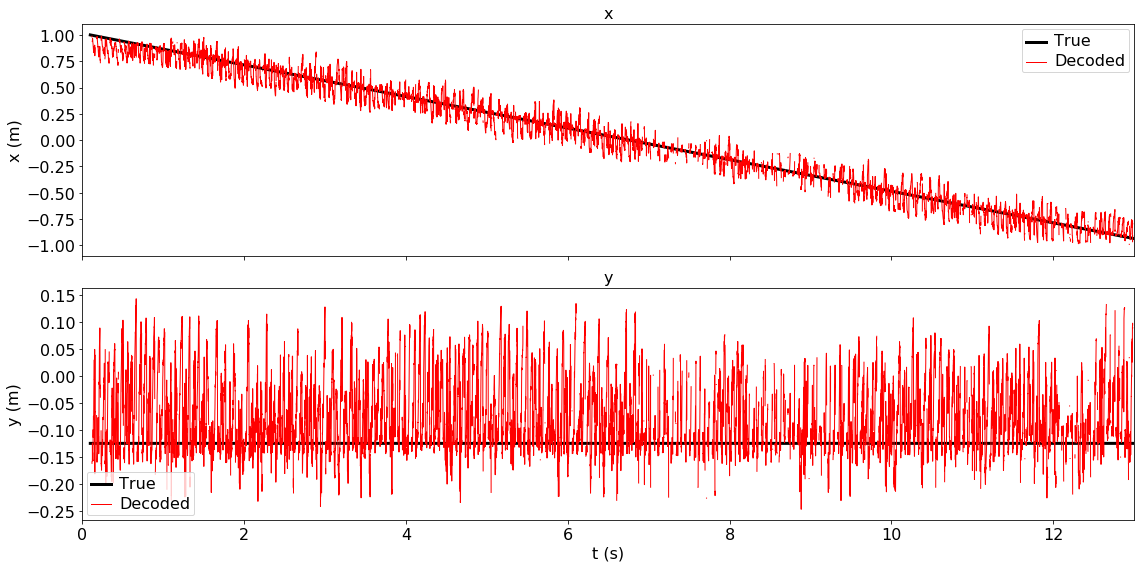

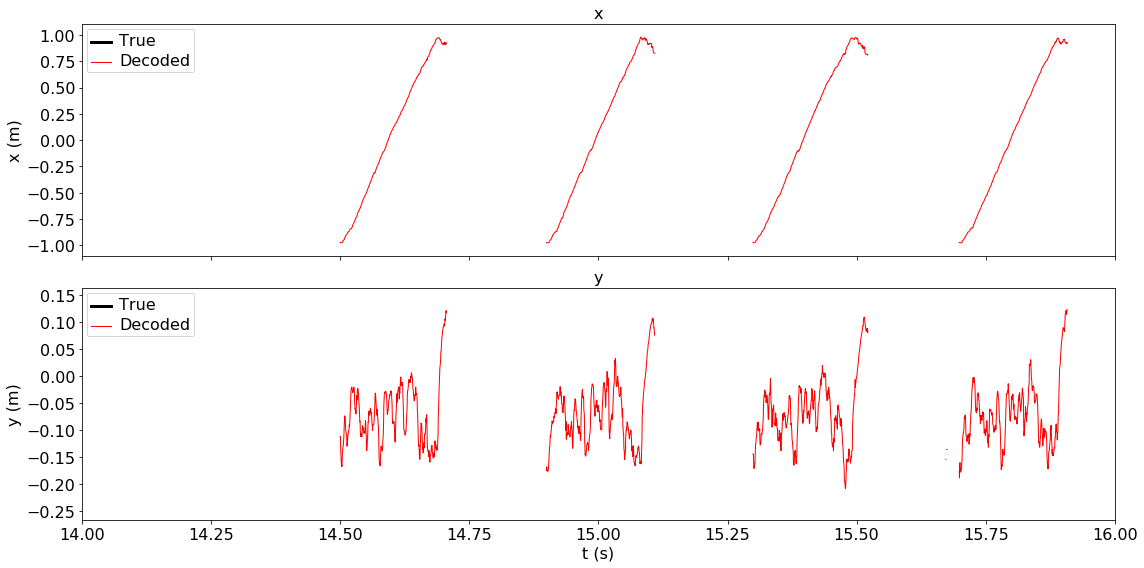

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), tight_layout=True, sharex=True)

axs[0].plot(rsp.ts, xs, color='k', lw=3)
axs[0].plot(ts_hat, xs_hat, color='r', lw=1)

axs[0].set_xlim(0, 13)
axs[0].set_ylabel('x (m)')
axs[0].set_title('x')
axs[0].legend(['True', 'Decoded'])

axs[1].plot(rsp.ts, ys, color='k', lw=3)
axs[1].plot(ts_hat, ys_hat, color='r', lw=1)

axs[1].set_xlim(0, 13)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('y (m)')
axs[1].set_title('y')
axs[1].legend(['True', 'Decoded'])

for ax in axs:
    set_font_size(ax, 16)
    
fig, axs = plt.subplots(2, 1, figsize=(16, 8), tight_layout=True, sharex=True)

axs[0].plot(rsp.ts, xs, color='k', lw=3)
axs[0].plot(ts_hat, xs_hat, color='r', lw=1)

axs[0].set_xlim(14, 16)
axs[0].set_ylabel('x (m)')
axs[0].set_title('x')
axs[0].legend(['True', 'Decoded'])

axs[1].plot(rsp.ts, ys, color='k', lw=3)
axs[1].plot(ts_hat, ys_hat, color='r', lw=1)

axs[0].set_xlim(14, 16)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('y (m)')
axs[1].set_title('y')
axs[1].legend(['True', 'Decoded'])

for ax in axs:
    set_font_size(ax, 16)

# Make animations

In [5]:
from anim import build_frames, create_mp4

In [6]:
# assign neuron positions
N = len(rsp.cell_types)
N_PC = np.sum(rsp.cell_types == 'PC')
N_INH = np.sum(rsp.cell_types == 'INH')

## PC positions as place field centers
positions_pfc = rsp.pfcs.copy()
## INH positions as uniform and random
positions_pfc[0, -N_INH:] = np.random.uniform(-0.5, 0.5, N_INH)
positions_pfc[1, -N_INH:] = np.random.uniform(-0.775, -0.375, N_INH)

## random positions
positions_rnd = np.nan * np.zeros((2, N))
positions_rnd[0, :] = np.random.uniform(-1, 1, N)
positions_rnd[1, :] = np.random.uniform(-1, 1, N)

## Save ntwk activity

In [8]:
save_dir = os.path.join(
    'smlns', 'lin_ridge', 'full',
    'trial_{}_seed_{}'.format(TRIAL, SEED),
    'ntwk_traj_decoded_info_0_19_60_fps',
)

box = (-1.1, 1.1, -.875, 0.35)

frames_ntwk_pfc, extra = build_frames.ntwk(
    frame_prfx=os.path.join(save_dir, 'frames_ntwk_pfc', 'frame'),
    rsp=rsp,
    
    t_start=0,
    t_end=19,
    positions=positions_pfc,
    box=box,
    fig_w=20,
    
    resting_size=50/4,
    spk_size=500/4,
    amp=1,
    non_spk_colors={'PC': 'k', 'INH': 'b'},
    spk_color='r',
    
    cxn_colors={},
    cxn_lws={},
    cxn_z_orders={},
    
    x_ticks=(-1.1, 0, 1.1),
    y_ticks=(-0.575, -0.25, 0.25),
    x_tick_labels=(-1.1, 0, 1.1),
    y_tick_labels=('INH', -0.25, 0.25),
    
    x_label='PFC_x (m)',
    y_label='PFC_y (m)',
    title='Ntwk Response',
    font_size=30,
    
    fps=60,
    frames_per_spk=1,
    show_timestamp=True,
    
    verbose=True,
    report_every=60)



Downsampling data from 2000.0 to 60 fps...
Downsampled.

Generating and saving 1140 frames spanning times 0.008000 to 18.991500 s...


/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


155 frames completed after 60.120 s...
303 frames completed after 120.281 s...
460 frames completed after 180.377 s...
619 frames completed after 240.453 s...
775 frames completed after 300.462 s...
937 frames completed after 360.726 s...
1107 frames completed after 421.003 s...
All frames written to disk.


In [9]:
fig_w, fig_h = extra['fig_size']

In [11]:
save_dir = os.path.join(
    'smlns', 'lin_ridge', 'full',
    'trial_{}_seed_{}'.format(TRIAL, SEED),
    'ntwk_traj_decoded_info_0_19_60_fps',
)

box = (-1.1, 1.1, -1.1, 1.1)

frames_ntwk_rnd, extra = build_frames.ntwk(
    frame_prfx=os.path.join(save_dir, 'frames_ntwk_rnd', 'frame'),
    rsp=rsp,
    
    t_start=0,
    t_end=19,
    positions=positions_rnd,
    box=box,
    fig_w=fig_w,
    fig_h=fig_h,
    
    resting_size=50/4,
    spk_size=500/4,
    amp=1,
    non_spk_colors={'PC': 'k', 'INH': 'b'},
    spk_color='r',
    
    cxn_colors={},
    cxn_lws={},
    cxn_z_orders={},
    
    x_ticks=(-1.1, 1.1),
    y_ticks=(-1.1, 1.1),
    x_tick_labels=(-1.1, 1.1),
    y_tick_labels=(-1.1, 1.1),
    
    x_label='X',
    y_label='Y',
    title='Ntwk Response',
    font_size=30,
    
    fps=60,
    frames_per_spk=1,
    show_timestamp=True,
    
    verbose=True,
    report_every=60)



Downsampling data from 2000.0 to 60 fps...
Downsampled.

Generating and saving 1140 frames spanning times 0.008000 to 18.991500 s...


/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


171 frames completed after 60.366 s...
343 frames completed after 120.425 s...
522 frames completed after 180.481 s...
699 frames completed after 240.730 s...
875 frames completed after 301.055 s...
1032 frames completed after 361.105 s...
All frames written to disk.


## Save true traj

In [28]:
from aux import Generic

traj = Generic(ts=rsp.ts, xys=xys)

In [29]:
from anim import build_frames

frames_traj, extra = build_frames.traj(
    frame_prfx=os.path.join(save_dir, 'frames_traj', 'frame'),
    traj=traj,
    
    t_start=0,
    t_end=19,
    box=(-1.1, 1.1, -0.3, 0.3),
    fig_w=fig_w,
    fig_h=fig_h,
    
    loc_size=1000,
    path_size=500,
    loc_color=(0, 0, 1, 0.3),
    path_color=(0, 0, 0),
    decay=0.3,
    
    x_ticks=(-1.1, 0, 1.1),
    y_ticks=(-0.25, 0, 0.25),
    x_tick_labels=(-1.1, 0, 1.1),
    y_tick_labels=(-0.25, 0, 0.25),
    
    x_label='x (m)',
    y_label='y (m)',
    title='True Trajectory',
    font_size=30,
    
    fps=60,
    show_timestamp=True,
    
    verbose=True,
    report_every=60)



Downsampling data from 2000.0 to 60 fps...
Downsampled.

Generating and saving 1140 frames spanning times 0.008000 to 18.991500 s...
543 frames completed after 60.113 s...
1040 frames completed after 120.235 s...
All frames written to disk.


## Save decoded traj

In [41]:
traj_hat = Generic(ts=ts_hat, xys=xys_hat)

In [44]:
from anim import build_frames

frames_traj_hat, extra = build_frames.traj(
    frame_prfx=os.path.join(save_dir, 'frames_traj_hat', 'frame'),
    traj=traj_hat,
    
    t_start=0,
    t_end=19,
    box=(-1.1, 1.1, -0.3, 0.3),
    fig_w=fig_w,
    fig_h=fig_h,
    
    loc_size=1000,
    path_size=500,
    loc_color=(0, 0, 1, 0.3),
    path_color=(0, 0, 0),
    decay=0.3,
    
    x_ticks=(-1.1, 0, 1.1),
    y_ticks=(-0.25, 0, 0.25),
    x_tick_labels=(-1.1, 0, 1.1),
    y_tick_labels=(-0.25, 0, 0.25),
    
    x_label='x (m)',
    y_label='y (m)',
    title='Decoded Trajectory',
    font_size=30,
    
    fps=60,
    show_timestamp=True,
    
    verbose=True,
    report_every=60)



Downsampling data from 2000.1295454251033 to 60 fps...
Downsampled.

Generating and saving 1140 frames spanning times 0.007894 to 18.991758 s...
540 frames completed after 60.062 s...
1054 frames completed after 120.104 s...
All frames written to disk.


## Metadata frames

In [62]:
# make metadata
texts = {
    'PL_TRAJ': 'PLACE-TUNED INPUT',
    'EC': 'BACKGROUND BARRAGE',
    'PL_TRIG': 'REPLAY_TRIGGER',
}

indicator_pl_traj = np.zeros(rsp.ts.shape, dtype=bool)
indicator_pl_traj[(C.TRAJ_START_T <= rsp.ts) & (rsp.ts < C.TRAJ_END_T)] = True

indicator_ec = np.zeros(rsp.ts.shape, dtype=bool)
indicator_ec[(C.T_EC <= rsp.ts)] = True

indicator_pl_trig = np.zeros(rsp.ts.shape, dtype=bool)

for ctr in range(C.N_REPLAY):
    t_start = ctr * C.ITVL_REPLAY + C.T_REPLAY
    t_end = t_start + 0.02
    indicator_pl_trig[(t_start <= rsp.ts) & (rsp.ts < t_end)] = True
    
indicators = {
    'PL_TRAJ': indicator_pl_traj,
    'EC': indicator_ec,
    'PL_TRIG': indicator_pl_trig,
}

meta = Generic(ts=rsp.ts, texts=texts, indicators=indicators)

In [63]:
frames_meta, extra = build_frames.meta(
    frame_prfx=os.path.join(save_dir, 'frames_meta', 'frame'),
    meta=meta,
    t_start=0,
    t_end=19,
    box=(-1, 1, -1, 1),
    fig_w=fig_w,
    fig_h=fig_h,
    
    text_xys={'PL_TRAJ': (-0.5, 0.5), 'EC': (-0.5, 0), 'PL_TRIG': (-0.5, -0.5)},
    colors={'PL_TRAJ': 'k', 'EC': 'g', 'PL_TRIG': 'r'},
    title='Stimulus summary',
    font_size=60,
    title_font_size=30,
    
    fps=60,
    show_timestamp=True,
    
    verbose=True,
    report_every=60)



Downsampling data from 2000.0 to 60 fps...
Downsampled.

Generating and saving 1140 frames spanning times 0.008000 to 18.991500 s...
782 frames completed after 60.018 s...
All frames written to disk.


# Merge frames

# Make movie

In [26]:
create_mp4(
    frames_ntwk_pfc,
    save_file=os.path.join(save_dir, 'ntwk_pfc_mov_30_fps'),
    playback_fps=30)

'smlns/lin_ridge/full/trial_25438_seed_17766/ntwk_traj_decoded_info_0_19_60_fps/ntwk_pfc_mov_30_fps.mp4'

In [ ]:
create_mp4(
    frames_ntwk_rnd,
    save_file=os.path.join(save_dir, 'ntwk_rnd_mov_30_fps'),
    playback_fps=30)

In [30]:
create_mp4(
    frames_traj,
    save_file=os.path.join(save_dir, 'traj_mov_30_fps'),
    playback_fps=30)

'smlns/lin_ridge/full/trial_25438_seed_17766/ntwk_traj_decoded_info_0_19_60_fps/traj_mov_30_fps.mp4'

In [45]:
create_mp4(
    frames_traj_hat,
    save_file=os.path.join(save_dir, 'traj_hat_mov_30_fps'),
    playback_fps=30)

'smlns/lin_ridge/full/trial_25438_seed_17766/ntwk_traj_decoded_info_0_19_60_fps/traj_hat_mov_30_fps.mp4'

In [64]:
create_mp4(
    frames_meta,
    save_file=os.path.join(save_dir, 'meta_mov_30_fps'),
    playback_fps=30)

'smlns/lin_ridge/full/trial_25438_seed_17766/ntwk_traj_decoded_info_0_19_60_fps/meta_mov_30_fps.mp4'